In [1]:
import sys, os
sys.path.append(os.path.abspath(
    os.getcwd()+"/core")
)

In [2]:
from core.quantum_error_correction_code import SurfaceCode, QEC
from core.neural_network import CNNDual, load_params
from core.evaluate_decoder import evaluate_mcnn_decoder, evaluate_pml_decoder

from jax import random
import jax.numpy as jnp
import json

key = random.key(42)

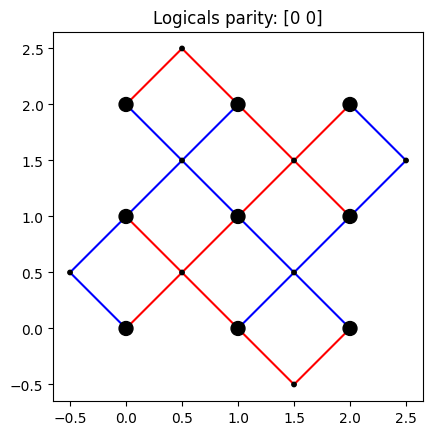

In [3]:
code = SurfaceCode(3)

deformation, key = code.random_deformation(key, jnp.zeros(code.num_data_qubits, dtype=jnp.int32))

parity_info = code.deformation_parity_info(deformation)

code.show(parity_info)

In [4]:
settings, model_params = load_params("data/CNN-G-3.json")
L = settings["CODE_DISTANCE"]
error_probs = settings["ERROR_PROBS"]

decoder_model = CNNDual(
    input_shape_1=(1, L+1, L+1),
    input_shape_2=(1, L, L),
    conv_layers_input_1=[tuple(int(v) for v in vals) for vals in settings["CONV_LAYERS_INPUT_1"]],
    conv_layers_input_2=[tuple(int(v) for v in vals) for vals in settings["CONV_LAYERS_INPUT_2"]],
    conv_layers_stage_2=[tuple(int(v) for v in vals) for vals in settings["CONV_LAYERS_STAGE_2"]],
    fc_layers=[int(v) for v in settings["FC_LAYERS"]],
)
decoder_model.layer_sizes

{'CNN_input_1': [(1, 4, 4), (8, 3, 3)],
 'CNN_input_2': [(1, 3, 3), (8, 3, 3)],
 'CNN_stage_2': [(8, 3, 3), (8, 2, 2)],
 'MLP_stage_3': [32, 50, 2]}

# CNN-G decoder

## Random search

In [5]:
def random_search_cnng(
    key,
    code: QEC,
    N: int,
    decoder_model: CNNDual,
    model_params: dict,
    error_probs: dict,
    batch_count: int = 10,
    batch_size: int = 1_000_000,
):
    history = jnp.empty(N, dtype=jnp.float32)
    best_deformation = jnp.empty(code.num_data_qubits, dtype=jnp.int32)
    best_error_rate = jnp.inf
    for i in range(N):
        deformation, key = code.random_deformation(key, allowed_deformations=jnp.arange(6))
        error_rate, _ = evaluate_mcnn_decoder(
            key,
            decoder_model,
            model_params,
            code,
            deformation,
            batch_count,
            batch_size,
            error_probs=error_probs,
        )
        print(f"Iteration {i+1}/{N} \t Deformation: {deformation} \t Error Rate: {error_rate:.2E}\t\t", end="\r")
        if error_rate < best_error_rate:
            print(f"Iteration {i+1}/{N} \t Deformation: {deformation} \t Error Rate: {error_rate:.2E}\t\t", end="\n")
            best_error_rate = error_rate
            best_deformation = deformation
        history = history.at[i].set(best_error_rate)
    return best_deformation, best_error_rate, history

In [6]:
R_deformation_cnng_3, R_ler_cnng_3, R_history_cnng_3 = random_search_cnng(
    random.key(42),
    code,
    N=405,
    decoder_model=decoder_model,
    model_params=model_params,
    error_probs=error_probs,
    batch_count=1,
    batch_size=1_000_000,
)
print(f"Solution \t\t Deformation: {R_deformation_cnng_3} \t Error Rate: {R_ler_cnng_3:.2E}\t\t", end="\n")

Iteration 1/405 	 Deformation: [4 3 5 5 4 3 0 3 2] 	 Error Rate: 3.75E-04		
Iteration 4/405 	 Deformation: [4 5 5 2 4 4 0 1 2] 	 Error Rate: 2.30E-04		
Iteration 5/405 	 Deformation: [1 1 3 4 1 5 1 1 3] 	 Error Rate: 1.97E-04		
Iteration 9/405 	 Deformation: [3 1 5 5 0 3 0 2 0] 	 Error Rate: 1.38E-04		
Iteration 12/405 	 Deformation: [5 3 2 3 0 2 3 3 4] 	 Error Rate: 1.14E-04		
Iteration 19/405 	 Deformation: [3 3 4 1 1 3 0 4 5] 	 Error Rate: 1.11E-04		
Iteration 72/405 	 Deformation: [0 0 4 2 2 1 3 3 4] 	 Error Rate: 8.90E-05		
Solution 		 Deformation: [0 0 4 2 2 1 3 3 4] 	 Error Rate: 8.90E-05		02E-04		


## Hill climb search

In [7]:
def hill_climb_search_cnng(
    key,
    code: QEC,
    N: int,
    decoder_model: CNNDual,
    model_params: dict,
    error_probs: dict,
    batch_count: int = 10,
    batch_size: int = 1_000_000,
):
    history = jnp.empty(N, dtype=jnp.float32)
    local_changes = lambda deformation: [
        deformation.at[n].set(d) 
        for n in range(code.num_data_qubits) 
        for d in range(6) 
        if deformation[n] != d
    ]

    best_deformation = jnp.zeros(code.num_data_qubits, dtype=jnp.int32)
    best_error_rate, _ = evaluate_mcnn_decoder(
        key,
        decoder_model,
        model_params,
        code,
        best_deformation,
        batch_count,
        batch_size,
        error_probs=error_probs,
    )
    deformation_candidates = local_changes(best_deformation)
    for i in range(N):
        print(f"Iteration {i+1}/{N}     ", end="\r")
        subkey, key = random.split(key)
        idx = random.randint(subkey, 1, minval=0, maxval=len(deformation_candidates))[0]
        deformation = deformation_candidates[idx]
        error_rate, _ = evaluate_mcnn_decoder(
            key,
            decoder_model,
            model_params,
            code,
            deformation,
            batch_count,
            batch_size,
            error_probs=error_probs,
        )
        print(f"Iteration {i+1}/{N} \t Deformation: {deformation} \t Error Rate: {error_rate:.2E}\t\t", end="\r")
        if error_rate < best_error_rate:
            print(f"Iteration {i+1}/{N} \t Deformation: {deformation} \t Error Rate: {error_rate:.2E}\t\t", end="\n")
            best_error_rate = error_rate
            best_deformation = deformation
            deformation_candidates = local_changes(best_deformation)
        else:
            deformation_candidates.pop(idx)
            if len(deformation_candidates) == 0:
                print("No more candidates, stopping search.\t\t\t\t\t")
                history = history.at[i:].set(best_error_rate)
                break
        history = history.at[i].set(best_error_rate)
    return best_deformation, best_error_rate, history

In [8]:
HC_deformation_cnng_3, HC_ler_cnng_3, HC_history_cnng_3 = hill_climb_search_cnng(
    random.key(42),
    code,
    N=405,
    decoder_model=decoder_model,
    model_params=model_params,
    error_probs=error_probs,
    batch_count=1,
    batch_size=1_000_000,
)
print(f"Solution \t\t Deformation: {HC_deformation_cnng_3} \t Error Rate: {HC_ler_cnng_3:.2E}\t\t", end="\n")

Iteration 1/405 	 Deformation: [5 0 0 0 0 0 0 0 0] 	 Error Rate: 1.36E-03		
Iteration 2/405 	 Deformation: [5 0 0 0 0 0 0 2 0] 	 Error Rate: 9.13E-04		
Iteration 3/405 	 Deformation: [5 2 0 0 0 0 0 2 0] 	 Error Rate: 6.75E-04		
Iteration 5/405 	 Deformation: [5 2 0 0 4 0 0 2 0] 	 Error Rate: 1.69E-04		
Iteration 7/405 	 Deformation: [5 3 0 0 4 0 0 2 0] 	 Error Rate: 1.52E-04		
Iteration 11/405 	 Deformation: [5 3 0 0 5 0 0 2 0] 	 Error Rate: 1.16E-04		
Iteration 17/405 	 Deformation: [3 3 0 0 5 0 0 2 0] 	 Error Rate: 1.04E-04		
Iteration 19/405 	 Deformation: [3 5 0 0 5 0 0 2 0] 	 Error Rate: 9.00E-05		
Iteration 35/405 	 Deformation: [4 5 0 0 5 0 0 2 0] 	 Error Rate: 8.80E-05		
Iteration 62/405 	 Deformation: [4 5 0 0 5 0 0 2 1] 	 Error Rate: 8.70E-05		
No more candidates, stopping search.					 1 0 0 2 1] 	 Error Rate: 6.28E-04		
Solution 		 Deformation: [4 5 0 0 5 0 0 2 1] 	 Error Rate: 8.70E-05		


# PML decoder

## Random search

In [9]:
def random_search_pml(
    key,
    code: QEC,
    N: int,
    error_probs: dict,
    batch_count: int = 10,
    batch_size: int = 1_000_000,
    exact=False,
):
    history = jnp.empty(N, dtype=jnp.float32)
    best_deformation = jnp.empty(code.num_data_qubits, dtype=jnp.int32)
    best_error_rate = jnp.inf
    for i in range(N):
        deformation, key = code.random_deformation(key, allowed_deformations=jnp.arange(6))
        error_rate, _ = evaluate_pml_decoder(
            key,
            code,
            deformation,
            batch_count,
            batch_size,
            error_probs=error_probs,
            exact=exact
        )
        print(f"Iteration {i+1}/{N} \t Deformation: {deformation} \t Error Rate: {error_rate:.2E}\t\t", end="\r")
        if error_rate < best_error_rate:
            print(f"Iteration {i+1}/{N} \t Deformation: {deformation} \t Error Rate: {error_rate:.2E}\t\t", end="\n")
            best_error_rate = error_rate
            best_deformation = deformation
        history = history.at[i].set(best_error_rate)
    return best_deformation, best_error_rate, history

In [10]:
R_deformation_pml_3, R_ler_pml_3, R_history_pml_3 = random_search_pml(
    random.key(42),
    code,
    N=351,
    error_probs=error_probs,
    batch_count=1,
    batch_size=1_000_000,
    exact=True,
)
print(f"Solution \t\t Deformation: {R_deformation_pml_3} \t Error Rate: {R_ler_pml_3:.2E}\t\t", end="\n")

Iteration 1/351 	 Deformation: [4 3 5 5 4 3 0 3 2] 	 Error Rate: 3.42E-04		
Iteration 2/351 	 Deformation: [3 0 4 4 2 0 0 0 5] 	 Error Rate: 3.33E-04		
Iteration 4/351 	 Deformation: [4 5 5 2 4 4 0 1 2] 	 Error Rate: 4.98E-05		
Iteration 22/351 	 Deformation: [3 2 3 2 5 0 1 2 3] 	 Error Rate: 4.67E-05		
Iteration 38/351 	 Deformation: [0 1 5 4 2 3 5 1 2] 	 Error Rate: 3.67E-05		
Iteration 265/351 	 Deformation: [2 5 1 3 5 2 5 0 3] 	 Error Rate: 2.49E-05		
Solution 		 Deformation: [2 5 1 3 5 2 5 0 3] 	 Error Rate: 2.49E-05		23E-04		


## Hill climb search

In [11]:
def hill_climb_search_pml(
    key,
    code: QEC,
    N: int,
    error_probs: dict,
    batch_count: int = 10,
    batch_size: int = 1_000_000,
    exact=False,
):
    history = jnp.empty(N, dtype=jnp.float32)
    local_changes = lambda deformation: [
        deformation.at[n].set(d) 
        for n in range(code.num_data_qubits) 
        for d in range(6) 
        if deformation[n] != d
    ]

    best_deformation = jnp.zeros(code.num_data_qubits, dtype=jnp.int32)
    best_error_rate, _ = evaluate_pml_decoder(
        key,
        code,
        best_deformation,
        batch_count,
        batch_size,
        error_probs=error_probs,
        exact=exact
    )
    deformation_candidates = local_changes(best_deformation)
    for i in range(N):
        print(f"Iteration {i+1}/{N}     ", end="\r")
        subkey, key = random.split(key)
        idx = random.randint(subkey, 1, minval=0, maxval=len(deformation_candidates))[0]
        deformation = deformation_candidates[idx]
        error_rate, _ = evaluate_pml_decoder(
            key,
            code,
            deformation,
            batch_count,
            batch_size,
            error_probs=error_probs,
            exact=exact
        )
        print(f"Iteration {i+1}/{N} \t Deformation: {deformation} \t Error Rate: {error_rate:.2E}\t\t", end="\r")
        if error_rate < best_error_rate:
            print(f"Iteration {i+1}/{N} \t Deformation: {deformation} \t Error Rate: {error_rate:.2E}\t\t", end="\n")
            best_error_rate = error_rate
            best_deformation = deformation
            deformation_candidates = local_changes(best_deformation)
        else:
            deformation_candidates.pop(idx)
            if len(deformation_candidates) == 0:
                print("No more candidates, stopping search.\t\t\t\t\t")
                history = history.at[i:].set(best_error_rate)
                break
        history = history.at[i].set(best_error_rate)
    return best_deformation, best_error_rate, history

In [12]:
HC_deformation_pml_3, HC_ler_pml_3, HC_history_pml_3 = hill_climb_search_pml(
    random.key(42),
    code,
    N=351,
    error_probs=error_probs,
    batch_count=1,
    batch_size=1_000_000,
    exact=True
)
print(f"Solution \t\t Deformation: {HC_deformation_pml_3} \t Error Rate: {HC_ler_pml_3:.2E}\t\t", end="\n")

Iteration 1/351 	 Deformation: [5 0 0 0 0 0 0 0 0] 	 Error Rate: 1.26E-03		
Iteration 2/351 	 Deformation: [5 0 0 0 0 0 0 2 0] 	 Error Rate: 7.99E-04		
Iteration 3/351 	 Deformation: [5 2 0 0 0 0 0 2 0] 	 Error Rate: 5.35E-04		
Iteration 5/351 	 Deformation: [5 2 0 0 4 0 0 2 0] 	 Error Rate: 5.95E-05		
Iteration 9/351 	 Deformation: [5 2 0 0 4 0 0 2 3] 	 Error Rate: 5.78E-05		
Iteration 17/351 	 Deformation: [5 2 0 2 4 0 0 2 3] 	 Error Rate: 5.38E-05		
Iteration 29/351 	 Deformation: [4 2 0 2 4 0 0 2 3] 	 Error Rate: 3.64E-05		
Iteration 36/351 	 Deformation: [4 2 0 2 4 2 0 2 3] 	 Error Rate: 2.57E-05		
Iteration 38/351 	 Deformation: [4 2 0 2 2 2 0 2 3] 	 Error Rate: 2.49E-05		
No more candidates, stopping search.					2 2 2 2 3] 	 Error Rate: 3.68E-05		
Solution 		 Deformation: [4 2 0 2 2 2 0 2 3] 	 Error Rate: 2.49E-05		


# Larger surface code sizes

## Distance 5

In [13]:
code = SurfaceCode(5)

settings, model_params = load_params("data/CNN-G-5.json")
L = settings["CODE_DISTANCE"]
error_probs = settings["ERROR_PROBS"]

decoder_model = CNNDual(
    input_shape_1=(1, L+1, L+1),
    input_shape_2=(1, L, L),
    conv_layers_input_1=[tuple(int(v) for v in vals) for vals in settings["CONV_LAYERS_INPUT_1"]],
    conv_layers_input_2=[tuple(int(v) for v in vals) for vals in settings["CONV_LAYERS_INPUT_2"]],
    conv_layers_stage_2=[tuple(int(v) for v in vals) for vals in settings["CONV_LAYERS_STAGE_2"]],
    fc_layers=[int(v) for v in settings["FC_LAYERS"]],
)
decoder_model.layer_sizes

{'CNN_input_1': [(1, 6, 6), (24, 5, 5)],
 'CNN_input_2': [(1, 5, 5), (24, 5, 5)],
 'CNN_stage_2': [(24, 5, 5), (24, 4, 4)],
 'MLP_stage_3': [384, 50, 2]}

In [14]:
R_deformation_cnng_5, R_ler_cnng_5, R_history_cnng_5 = random_search_cnng(
    random.key(42),
    code,
    N=1068,
    decoder_model=decoder_model,
    model_params=model_params,
    error_probs=error_probs,
    batch_count=2,
    batch_size=500_000,
)
print(f"Solution \t\t Deformation: {R_deformation_cnng_5} \t Error Rate: {R_ler_cnng_5:.2E}\t\t", end="\n")

Iteration 1/1068 	 Deformation: [4 3 5 5 4 3 0 3 2 5 4 3 0 3 1 4 5 1 5 1 5 5 4 1 3] 	 Error Rate: 7.10E-05		
Iteration 8/1068 	 Deformation: [2 2 4 3 4 2 2 3 3 0 1 0 5 2 5 1 4 4 3 3 5 1 0 4 1] 	 Error Rate: 7.00E-05		
Iteration 9/1068 	 Deformation: [3 1 5 5 0 3 0 2 0 1 0 1 5 3 3 3 5 3 2 5 0 5 4 4 4] 	 Error Rate: 5.60E-05		
Iteration 60/1068 	 Deformation: [0 4 4 4 5 4 4 2 4 4 1 4 1 3 5 0 5 1 5 4 5 4 0 2 0] 	 Error Rate: 4.60E-05		
Iteration 335/1068 	 Deformation: [0 2 0 3 3 1 1 4 5 0 5 5 3 3 3 3 1 1 2 4 4 2 3 4 1] 	 Error Rate: 3.90E-05		
Iteration 1042/1068 	 Deformation: [2 1 3 3 1 3 1 1 5 0 5 4 3 3 4 3 5 0 5 2 2 3 2 1 0] 	 Error Rate: 3.80E-05		
Solution 		 Deformation: [2 1 3 3 1 3 1 1 5 0 5 4 3 3 4 3 5 0 5 2 2 3 2 1 0] 	 Error Rate: 3.80E-05		7.70E-05		


In [15]:
HC_deformation_cnng_5, HC_ler_cnng_5, HC_history_cnng_5 = hill_climb_search_cnng(
    random.key(42),
    code,
    N=1068,
    decoder_model=decoder_model,
    model_params=model_params,
    error_probs=error_probs,
    batch_count=2,
    batch_size=500_000,
)
print(f"Solution \t\t Deformation: {HC_deformation_cnng_5} \t Error Rate: {HC_ler_cnng_5:.2E}\t\t", end="\n")

Iteration 1/1068 	 Deformation: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 5 0 0 0 0 0] 	 Error Rate: 2.59E-04		
Iteration 5/1068 	 Deformation: [0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 5 0 0 0 0 0] 	 Error Rate: 2.33E-04		
Iteration 6/1068 	 Deformation: [0 0 0 0 0 0 0 0 5 0 0 0 4 0 0 0 0 0 0 5 0 0 0 0 0] 	 Error Rate: 2.15E-04		
Iteration 7/1068 	 Deformation: [0 0 0 0 0 0 0 0 5 0 0 0 4 0 0 0 0 0 0 3 0 0 0 0 0] 	 Error Rate: 1.85E-04		
Iteration 8/1068 	 Deformation: [0 0 0 0 4 0 0 0 5 0 0 0 4 0 0 0 0 0 0 3 0 0 0 0 0] 	 Error Rate: 1.51E-04		
Iteration 16/1068 	 Deformation: [0 0 0 0 4 0 0 0 5 0 0 0 4 0 0 0 0 0 0 3 0 4 0 0 0] 	 Error Rate: 1.32E-04		
Iteration 17/1068 	 Deformation: [0 0 0 0 4 0 0 0 5 0 0 0 4 0 0 0 0 0 0 3 0 4 0 4 0] 	 Error Rate: 1.00E-04		
Iteration 28/1068 	 Deformation: [0 0 0 0 4 0 0 0 5 0 0 0 4 0 0 3 0 0 0 3 0 4 0 4 0] 	 Error Rate: 8.90E-05		
Iteration 36/1068 	 Deformation: [0 0 0 0 4 0 0 0 5 0 0 0 4 0 0 3 0 0 0 3 0 4 0 4 3] 	 Error Rate: 7.60E-05		
Iteration 37/10

# Distance 7

In [16]:
code = SurfaceCode(7)

settings, model_params = load_params("data/CNN-G-7.json")
L = settings["CODE_DISTANCE"]
error_probs = settings["ERROR_PROBS"]

decoder_model = CNNDual(
    input_shape_1=(1, L+1, L+1),
    input_shape_2=(1, L, L),
    conv_layers_input_1=[tuple(int(v) for v in vals) for vals in settings["CONV_LAYERS_INPUT_1"]],
    conv_layers_input_2=[tuple(int(v) for v in vals) for vals in settings["CONV_LAYERS_INPUT_2"]],
    conv_layers_stage_2=[tuple(int(v) for v in vals) for vals in settings["CONV_LAYERS_STAGE_2"]],
    fc_layers=[int(v) for v in settings["FC_LAYERS"]],
)
decoder_model.layer_sizes

{'CNN_input_1': [(1, 8, 8), (48, 7, 7)],
 'CNN_input_2': [(1, 7, 7), (48, 7, 7)],
 'CNN_stage_2': [(48, 7, 7), (48, 6, 6)],
 'MLP_stage_3': [1728, 50, 2]}

In [17]:
R_deformation_cnng_7, R_ler_cnng_7, R_history_cnng_7 = random_search_cnng(
    random.key(42),
    code,
    N=1045,
    decoder_model=decoder_model,
    model_params=model_params,
    error_probs=error_probs,
    batch_count=10,
    batch_size=100_000,
)
print(f"Solution \t\t Deformation: {R_deformation_cnng_7} \t Error Rate: {R_ler_cnng_7:.2E}\t\t", end="\n")

Iteration 1/1045 	 Deformation: [4 3 5 5 4 3 0 3 2 5 4 3 0 3 1 4 5 1 5 1 5 5 4 1 3 1 1 2 0 3 0 1 0 5 1 4 4
Iteration 1/1045 	 Deformation: [4 3 5 5 4 3 0 3 2 5 4 3 0 3 1 4 5 1 5 1 5 5 4 1 3 1 1 2 0 3 0 1 0 5 1 4 4
 3 3 1 2 2 2 0 2 5 0 2 1] 	 Error Rate: 1.96E-04		
Iteration 2/1045 	 Deformation: [3 0 4 4 2 0 0 0 5 3 2 4 3 3 4 3 3 1 3 0 3 3 4 5 4 2 1 2 5 2 5 3 3 1 1 1 0
Iteration 2/1045 	 Deformation: [3 0 4 4 2 0 0 0 5 3 2 4 3 3 4 3 3 1 3 0 3 3 4 5 4 2 1 2 5 2 5 3 3 1 1 1 0
 0 0 4 4 2 4 1 2 3 3 0 0] 	 Error Rate: 1.30E-04		
Iteration 3/1045 	 Deformation: [0 4 5 1 5 0 0 1 4 1 5 3 3 2 0 0 5 4 2 1 2 3 2 1 1 0 2 2 4 5 4 4 4 4 2 1 2
Iteration 4/1045 	 Deformation: [4 5 5 2 4 4 0 1 2 5 5 2 4 0 2 1 0 5 1 4 5 2 5 5 5 4 5 1 5 4 0 3 3 1 3 4 1
Iteration 5/1045 	 Deformation: [1 1 3 4 1 5 1 1 3 3 5 1 4 2 1 1 1 1 0 3 1 4 3 3 2 1 2 4 2 4 1 2 3 5 4 3 4
Iteration 6/1045 	 Deformation: [5 4 0 2 0 5 1 0 5 0 3 0 0 1 1 1 1 0 0 4 5 4 4 4 3 0 5 4 2 5 4 3 5 1 4 2 3
Iteration 7/1045 	 Deformation: [5 2 2 4 3

In [18]:
HC_deformation_cnng_7, HC_ler_cnng_7, HC_history_cnng_7 = hill_climb_search_cnng(
    random.key(42),
    code,
    N=1045,
    decoder_model=decoder_model,
    model_params=model_params,
    error_probs=error_probs,
    batch_count=10,
    batch_size=100_000,
)
print(f"Solution \t\t Deformation: {HC_deformation_cnng_7} \t Error Rate: {HC_ler_cnng_7:.2E}\t\t", end="\n")

Iteration 1/1045 	 Deformation: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
Iteration 2/1045 	 Deformation: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
Iteration 3/1045 	 Deformation: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
Iteration 4/1045 	 Deformation: [0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
Iteration 4/1045 	 Deformation: [0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0] 	 Error Rate: 4.28E-04		
Iteration 5/1045 	 Deformation: [0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
Iteration 6/1045 	 Deformation: [0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
Iteration 6/1045 	 Deformation: [0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 5] 	 Error Rate: 4.18E-04		
Iteration 7/1045 	 Deformation: [0 0 0 0 0

# Results

In [19]:
results = {
    "Deformations": {
        "Random": {
            "CNN-G": {
                3: R_deformation_cnng_3.tolist(),
                5: R_deformation_cnng_5.tolist(),
                7: R_deformation_cnng_7.tolist(),
            },
            "PML": {
                3: R_deformation_pml_3.tolist(),
            },
        },
        "Hill Climb": {
            "CNN-G": {
                3: HC_deformation_cnng_3.tolist(),
                5: HC_deformation_cnng_5.tolist(),
                7: HC_deformation_cnng_7.tolist(),
            },
            "PML": {
                3: HC_deformation_pml_3.tolist(),
            },
        },
    },
    "Logical Error Rates": {
        "Random": {
            "CNN-G": {
                3: R_ler_cnng_3.tolist(),
                5: R_ler_cnng_5.tolist(),
                7: R_ler_cnng_7.tolist(),
            },
            "PML": {
                3: R_ler_pml_3.tolist(),
            },
        },
        "Hill Climb": {
            "CNN-G": {
                3: HC_ler_cnng_3.tolist(),
                5: HC_ler_cnng_5.tolist(),
                7: HC_ler_cnng_7.tolist(),
            },
            "PML": {
                3: HC_ler_pml_3.tolist(),
            },
        },
    },
    "LER Histories": {
        "Random": {
            "CNN-G": {
                3: R_history_cnng_3.tolist(),
                5: R_history_cnng_5.tolist(),
                7: R_history_cnng_7.tolist(),
            },
            "PML": {
                3: R_history_pml_3.tolist(),
            },
        },
        "Hill Climb": {
            "CNN-G": {
                3: HC_history_cnng_3.tolist(),
                5: HC_history_cnng_5.tolist(),
                7: HC_history_cnng_7.tolist(),
            },
            "PML": {
                3: HC_history_pml_3.tolist(),
            },
        },
    },
}
with open("data/non-ml-results-extended.json", "w") as f:
    json.dump(results, f, indent=4)
print("Results saved to results.json")

Results saved to results.json
